# Setup

In [6]:
import os
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rs
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(
    context="notebook",
    style="darkgrid",
    palette="deep",
)

In [7]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F

spark = (
    SparkSession.builder.master("local[*]")
    .config("spark.driver.memory", "128g")
    .config("spark.ui.showConsoleProgress", False)
    .getOrCreate()
)
sc = spark.sparkContext
sc.defaultParallelism

128

Fix formatting of spark dataframes.

In [8]:
from IPython.core.display import HTML

# fix spark wrapping
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Data Acquisition and Cleaning

In [9]:
# lets use EPSG:3857 as our coordinate reference system
project_crs = 3857

## PJM Energy Data

### PJM Regions

PJM is composed of 21 different regions. Public data is only given on a by region basis (electricity grid is considered critical infrastructure). We requested more detailed data for academic purposes, but it probably will not get approved.

PJM does not provide shapefiles for the regions, so we will have to make our own. Turns out that the web developer who designed the PJM system map used a service called ArgGIS to host the map. Turns out that the Penn library computers have access to the software so we could export the image as a GeoTiff -- a raster image with encoded geospatial data.

In [18]:
!wget "https://docs.google.com/uc?export=download&id=1bAzsavcp4ZfkcmkQ7DhjxpqmLmlN4Pa0" -O data/pjm.tif

--2021-12-15 16:53:07--  https://docs.google.com/uc?export=download&id=1bAzsavcp4ZfkcmkQ7DhjxpqmLmlN4Pa0
Resolving docs.google.com (docs.google.com)... 142.250.80.14, 2607:f8b0:4006:80a::200e
Connecting to docs.google.com (docs.google.com)|142.250.80.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p3hct1nhu5leacpkh24voeqnn7tjudee/1639587150000/03939079566282805889/*/1bAzsavcp4ZfkcmkQ7DhjxpqmLmlN4Pa0?e=download [following]
--2021-12-15 16:53:09--  https://doc-10-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p3hct1nhu5leacpkh24voeqnn7tjudee/1639587150000/03939079566282805889/*/1bAzsavcp4ZfkcmkQ7DhjxpqmLmlN4Pa0?e=download
Resolving doc-10-6g-docs.googleusercontent.com (doc-10-6g-docs.googleusercontent.com)... 142.250.64.97, 2607:f8b0:4006:807::2001
Connecting to doc-10-6g-docs.googleusercontent.com (doc-10-6g-docs.googleus

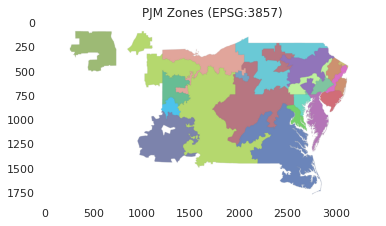

In [20]:
zones_fp = "data/pjm.tif"
zones_geo = rs.open(zones_fp)
zones_img = np.moveaxis(zones_geo.read(), 0, -1)

fig, ax = plt.subplots()
ax.grid(False)
plt.imshow(zones_img)
plt.title(f"PJM Zones ({zones_geo.crs})")
plt.show()

### Zone segmentation 

Unfortunately, the image is just a multi-colored raster. We need to split it up into the 21 zones ourselves. We actually _ignore_ the "OVEC" zone because it is just a dot on the map. We are left with 21 zones.

To segment the image into zones we used `np.unique` to find unique colors in the image and sorted them by the number of occurances. The largest color is the white background, but the next 20 are our zones in descending order of area. The only wrinke is that the perimiter of some zones is a shade of their color and this perimiter is larger than the area of the smallest zone.

In [ ]:
import cv2 as cv
import ipywidgets as widgets
from shapely.geometry import MultiPolygon, Polygon

zone_names = [
    "aep",
    "dom",
    "ap",
    "ekpc",
    "pn",
    "atsi",
    "ce",
    "pl",
    "day",
    "dpl",
    "jc",
    "me",
    "ae",
    "deok",
    "pe",
    "bc",
    "pep",
    "ps",
    "duq",
    "",
    "",
    "reco",
]

zones_flat = zones_img.reshape(-1, 3)
colors, counts = np.unique(zones_flat, axis=0, return_counts=True)
colors = colors[np.argsort(-counts)[1 : 1 + len(zone_names)]]

zone_contours = {}
plots = []
for color, zone in zip(colors, zone_names):
    mask = (zones_flat == color).all(axis=1).reshape(zones_img.shape[:2])
    if zone == "":
        continue
    masked = np.where(mask[..., None], zones_img, zones_img // 3)

    # detect contours
    contours, hierarchy = cv.findContours(
        (mask * 255).astype("uint8").copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE
    )
    masked = cv.drawContours(masked.copy(), contours, -1, (255, 0, 255), 4)

    # save data for later
    zone_contours[zone] = contours

    out = widgets.Output()
    with out:
        fig, ax = plt.subplots()
        ax.grid(False)
        plt.imshow(masked)
        plt.title(zone)
        plt.show()
    plots.append(out)
# tile the plots like a boss
widgets.Box(plots, layout=widgets.Layout(flex_flow="row wrap"))

Box(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output…

Now that we have the contours we can work with the geometry directory in GeoPandas.

In [ ]:
import folium
import folium.plugins

zone_names = []
geometries = []
for zone_name, contours in zone_contours.items():
    contours = [
        np.apply_along_axis(
            lambda x: zones_geo.transform * x, 1, contour.reshape(-1, 2)
        )
        for contour in contours
    ]
    geometry = MultiPolygon(
        [Polygon(contour) for contour in contours if contour.shape[0] > 2]
    )
    zone_names.append(zone_name)
    geometries.append(geometry)
zone_df = gpd.GeoDataFrame(
    {"zone": zone_names, "geometry": geometries}, crs=zones_geo.crs.to_wkt()
).to_crs(project_crs)

In [ ]:
m = zone_df.explore("zone")
m.add_child(folium.plugins.ScrollZoomToggler())

### Download the load data

In [ ]:
import shutil
import tempfile
from functools import partial
from time import sleep

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait


def download_pjm_year(feed, year):
    feed_dir = os.path.join("data/pjm", feed)
    dst = os.path.join(feed_dir, f"{year}.csv")
    if os.path.exists(dst):
        return

    with tempfile.TemporaryDirectory() as tmp_dir:
        src = os.path.join(tmp_dir, f"{feed}.csv")

        options = webdriver.FirefoxOptions()
        options.headless = True
        options.set_preference("browser.download.folderList", 2)
        options.set_preference("browser.download.dir", tmp_dir)
        options.set_preference("browser.download.useDownloadDir", True)
        options.set_preference("browser.download.manager.showWhenStarting", False)
        options.set_preference(
            "browser.helperApps.neverAsk.saveToDisk",
            "application/csv, application/octet-stream, text/csv, text/plain",
        )
        with webdriver.Firefox(options=options) as driver:
            driver.get(f"https://dataminer2.pjm.com/feed/{feed}")
            WebDriverWait(driver, 60).until(
                EC.presence_of_element_located(
                    (By.ID, "span_sortable_datetime_beginning_ept")
                )
            ).click()
            start = driver.find_element(
                By.XPATH,
                "//div[@class='datepicker-list-wrapper']//input[@default-value='defaultStartDate']",
            )
            end = driver.find_element(
                By.XPATH,
                "//div[@class='datepicker-list-wrapper']//input[@default-value='defaultEndDate']",
            )
            submit = driver.find_element(By.XPATH, "//button[text()='Submit']")
            download = driver.find_element(By.CLASS_NAME, "dm-download")

            start.send_keys(Keys.CONTROL + "a")
            start.send_keys(f"1/1/{year}")
            end.send_keys(Keys.CONTROL + "a")
            end.send_keys(f"12/31/{year}")
            submit.click()
            sleep(1)

            download.click()
            print(f"Export {year} started.")
            while not os.path.exists(src):
                sleep(0.1)
            print(f"Download {year} started.")

            prev_size = 0
            # wait until download finishes
            while True:
                sleep(5)
                size = os.path.getsize(src)
                if (size - prev_size) == 0:
                    break
                prev_size = size
            print(f"Download {year} finished.")
            sleep(10)  # make sure download is finished

        # move file to feed dir
        shutil.move(src, dst)


def download_pjm(feed, start_year, end_year):
    feed_dir = os.path.join("data/pjm", feed)
    if not os.path.exists(feed_dir):
        os.makedirs(feed_dir)
    with ThreadPoolExecutor() as e:
        years = range(start_year, end_year + 1)
        list(map(partial(download_pjm_year, feed), years))


# download_pjm("hrl_load_estimated", 1998, 2020)
download_pjm("hrl_load_metered", 1998, 2020)

### Load and Clean
First we read the data from a CSV.

In [ ]:
pjm_raw_sdf = spark.read.csv(
    glob("data/pjm/hrl_load_metered/*.csv"), header=True, inferSchema=True
)

Then we clean the data. We only need to convert a string datatime to a timestemp.

In [ ]:
pjm_hourly_sdf = pjm_raw_sdf.select(
    F.to_timestamp(pjm_raw_sdf.datetime_beginning_ept, "M/d/yyyy h:mm:ss a").alias(
        "datetime"
    ),
    F.lower("zone").alias("zone"),
    "mw",
).orderBy("datetime")
pjm_hourly_sdf.show(5)

+-------------------+----+------+
|           datetime|zone|    mw|
+-------------------+----+------+
|1998-01-01 00:00:00| gpu|1341.0|
|1998-01-01 00:00:00|cnct|1881.0|
|1998-01-01 00:00:00| gpu|2204.0|
|1998-01-01 00:00:00|  bc|3779.0|
|1998-01-01 00:00:00|cnct|1210.0|
+-------------------+----+------+
only showing top 5 rows



### Daily average
Unfortunately we only have daily weather data. 
While origianlly we planned adding a variable indicating the time of day as a feature, we decided on looking at the total energy consumption over a day.
We sill have over 60k entries in our dataset.

In [ ]:
pjm_sdf = (
    pjm_hourly_sdf.groupby(F.to_date("datetime").alias("date"), "zone")
    .agg(F.sum("mw").alias("mw"))
    .orderBy("date")
)
pjm_sdf.show(5)

+----------+----+--------+
|      date|zone|      mw|
+----------+----+--------+
|1998-01-01|cnct| 75914.0|
|1998-01-01| gpu|132094.0|
|1998-01-01| pep| 79139.0|
|1998-01-01|  pe|100632.0|
|1998-01-01|  ps|104738.0|
+----------+----+--------+
only showing top 5 rows



### Missing Values

Let's pivot the table since we only care about the zone and the load in MW.

In [ ]:
mw_sdf = pjm_sdf.groupby("date").pivot("zone").mean()
mw_sdf.show(5)

21/12/15 04:02:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+----+----+----+----+-------+----+-------+----+----+----+----+----+----+--------+----+----+----+--------+-------+--------+----+--------+----+--------+
|      date|  ae| aep|  ap|atsi|     bc|  ce|   cnct| day|deok| dom| dpl| duq|ekpc|     gpu|  jc|  me|ovec|      pe|    pep|      pl|  pn|      ps|reco|     rto|
+----------+----+----+----+----+-------+----+-------+----+----+----+----+----+----+--------+----+----+----+--------+-------+--------+----+--------+----+--------+
|1998-01-01|null|null|null|null|92219.0|null|75914.0|null|null|null|null|null|null|132094.0|null|null|null|100632.0|79139.0|111963.0|null|104738.0|null|696699.0|
|1998-01-02|null|null|null|null|82729.0|null|70037.0|null|null|null|null|null|null|131486.0|null|null|null| 97982.0|74421.0|107002.0|null|109452.0|null|673109.0|
|1998-01-03|null|null|null|null|74806.0|null|63224.0|null|null|null|null|null|null|116648.0|null|null|null| 87801.0|64876.0| 90866.0|null| 98948.0|null|597169.0|
|1998-01-04|null|null|null|n

Let's look at the data by month.

In [ ]:
w = Window.partitionBy(F.year(mw_sdf.date), F.month(mw_sdf.date))
mw_monthly_sdf = (
    mw_sdf.withColumn("date", F.to_date(F.min(mw_sdf.date).over(w)))  # .fillna(0)
    .groupby("date")
    .agg(
        *(
            F.sum(F.col(c).isNull().cast("int")).alias(c)
            for c in mw_sdf.columns
            if c != "date"
        )
    )
    .orderBy(F.col("date").asc())
)
mw_monthly_sdf.show(5)

+----------+---+---+---+----+---+---+----+---+----+---+---+---+----+---+---+---+----+---+---+---+---+---+----+---+
|      date| ae|aep| ap|atsi| bc| ce|cnct|day|deok|dom|dpl|duq|ekpc|gpu| jc| me|ovec| pe|pep| pl| pn| ps|reco|rto|
+----------+---+---+---+----+---+---+----+---+----+---+---+---+----+---+---+---+----+---+---+---+---+---+----+---+
|1998-01-01| 31| 31| 31|  31|  0| 31|   0| 31|  31| 31| 31| 31|  31|  0| 31| 31|  31|  0|  0|  0| 31|  0|  31|  0|
|1998-02-01| 28| 28| 28|  28|  0| 28|   0| 28|  28| 28| 28| 28|  28|  0| 28| 28|  28|  0|  0|  0| 28|  0|  28|  0|
|1998-03-01| 31| 31| 31|  31|  0| 31|   0| 31|  31| 31| 31| 31|  31|  0| 31| 31|  31|  0|  0|  0| 31|  0|  31|  0|
|1998-04-01| 30| 30| 30|  30|  0| 30|   0| 30|  30| 30| 30| 30|  30|  0| 30| 30|  30|  0|  0|  0| 30|  0|  30|  0|
|1998-05-01| 31| 31| 31|  31|  0| 31|   0| 31|  31| 31| 31| 31|  31|  0| 31| 31|  31|  0|  0|  0| 31|  0|  31|  0|
+----------+---+---+---+----+---+---+----+---+----+---+---+---+----+---+---+---+

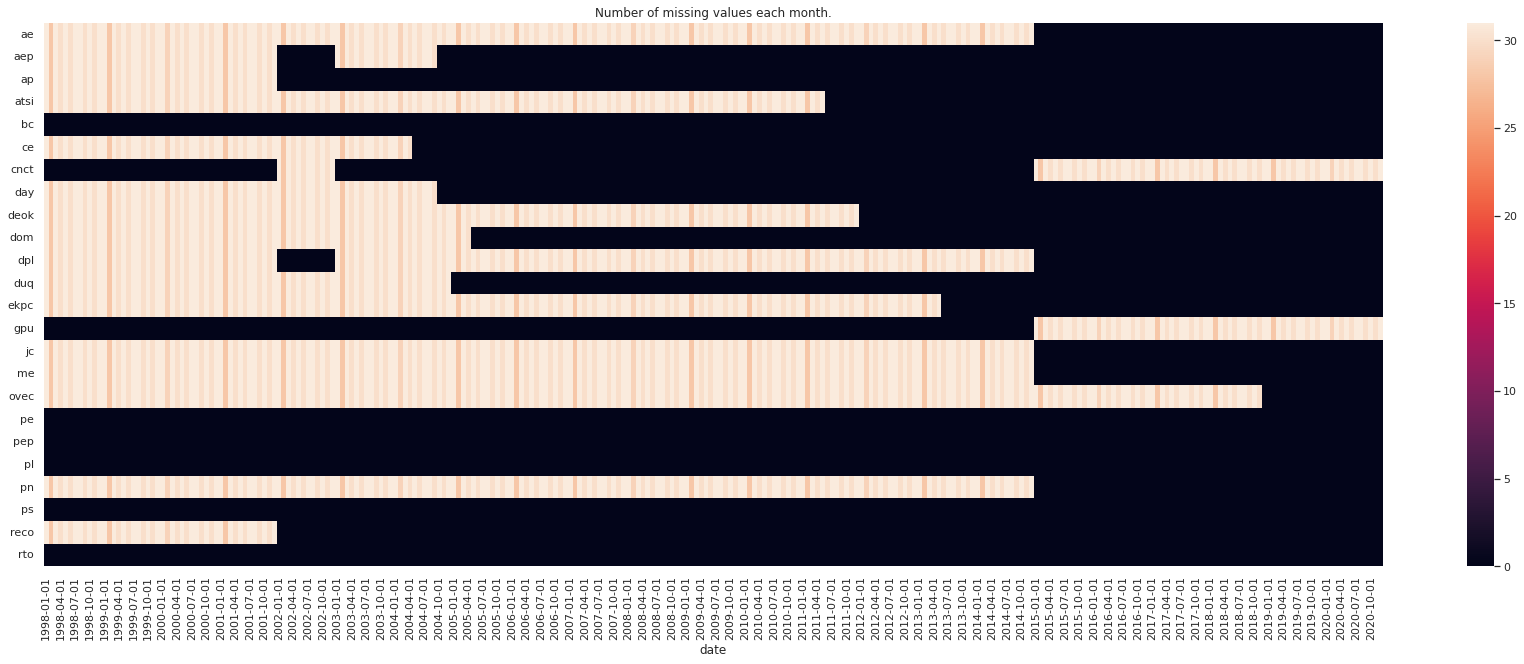

In [ ]:
plt.figure(figsize=(30, 10))
mw_monthly_df = mw_monthly_sdf.toPandas().set_index("date")
sns.heatmap(data=mw_monthly_df.transpose())
plt.title("Number of missing values each month.")
plt.show()

## Population Data

In [19]:
!wget "https://docs.google.com/uc?export=download&id=1tTRy0LcC2mkEH0VX3LrY-rLCjbYWnyJD" -O data/popCount.tif

--2021-12-15 16:53:36--  https://docs.google.com/uc?export=download&id=1tTRy0LcC2mkEH0VX3LrY-rLCjbYWnyJD
Resolving docs.google.com (docs.google.com)... 142.250.80.14, 2607:f8b0:4006:80a::200e
Connecting to docs.google.com (docs.google.com)|142.250.80.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8dfbgmnj2p798drvl1n1mlqc676ahuls/1639587150000/03939079566282805889/*/1tTRy0LcC2mkEH0VX3LrY-rLCjbYWnyJD?e=download [following]
--2021-12-15 16:53:38--  https://doc-0o-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8dfbgmnj2p798drvl1n1mlqc676ahuls/1639587150000/03939079566282805889/*/1tTRy0LcC2mkEH0VX3LrY-rLCjbYWnyJD?e=download
Resolving doc-0o-6g-docs.googleusercontent.com (doc-0o-6g-docs.googleusercontent.com)... 142.250.64.97, 2607:f8b0:4006:807::2001
Connecting to doc-0o-6g-docs.googleusercontent.com (doc-0o-6g-docs.googleus

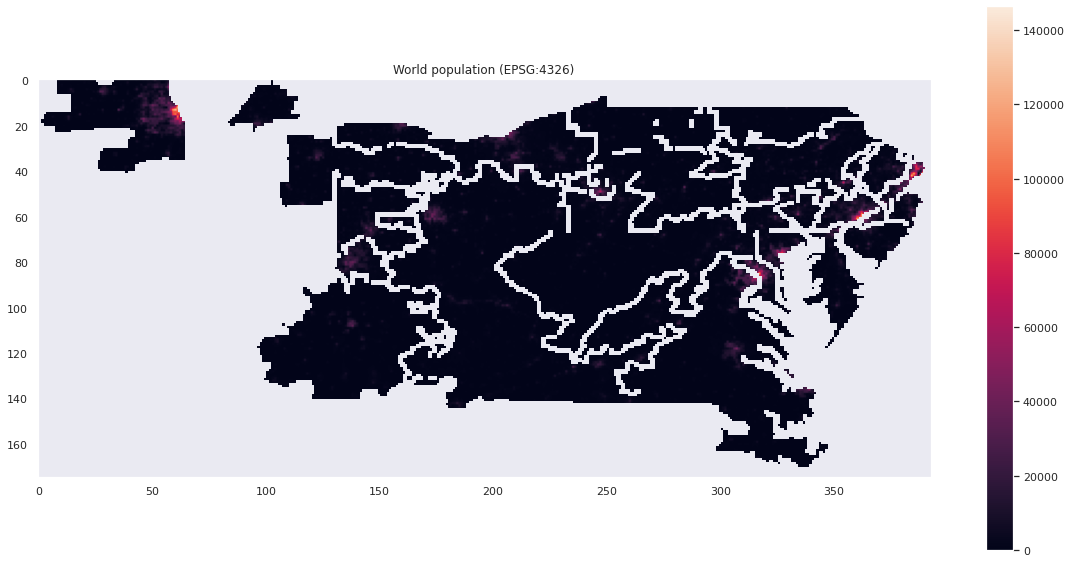

,zone,population
0,aep,7.585562e+06
1,dom,3.013688e+06
2,ap,6.000444e+06
3,ekpc,1.707814e+06
4,pn,1.344980e+06
5,atsi,4.640880e+06
6,ce,8.784918e+06
7,pl,2.729372e+06
8,day,1.205216e+06
9,dpl,1.186093e+06


In [ ]:
import rasterio.mask

population_fp = "data/popCount.tif"
zone_crs_df = zone_df.to_crs(4326)

with rs.open(population_fp) as src:
    shapes = [p for mp in zone_crs_df.geometry for p in mp.geoms]
    out_image, out_transform = rs.mask.mask(src, shapes, crop=True)

    out_image[out_image < 0] = np.nan

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.grid(False)
    plt.imshow(np.squeeze(out_image))
    plt.title(f"World population ({src.crs})")
    plt.colorbar()
    plt.show()

sumList = []
zone_names = list(zone_df["zone"].unique())
for name in zone_names:
    shapes = zone_df[zone_df["zone"] == name].to_crs(4326).iloc[0].geometry
    with rs.open(population_fp) as src:
        out_image, out_transform = rs.mask.mask(src, shapes.geoms, crop=False)
        out_meta = src.meta
        out_meta.update(
            {
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )
        out_image[out_image < 0] = 0
        sumList.append(out_image.sum())

population_df = pd.DataFrame(
    list(zip(zone_names, sumList)), columns=["zone", "population"]
)
display(population_df)

## Weather Data

### Find where are the stations

In [ ]:
import pandas_gbq
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    "./api_keys/gc.json"
)
bq = bigquery.Client(credentials=credentials)
pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = credentials.project_id

In [ ]:
# WARNING: when making queries ensure you don't download too much data from the API.
station_df = pd.read_gbq(
    """
SELECT * 
FROM `bigquery-public-data.noaa_gsod.stations`
WHERE country = 'US'
"""
)

We obtain the data and put it into a geopandas dataframe. Then we do a spatial join with the zone data to get the zone.

In [ ]:
station_gdf = gpd.GeoDataFrame(
    station_df,
    geometry=gpd.points_from_xy(station_df["lon"], station_df["lat"]),
    crs="EPSG:4326",
).to_crs(project_crs)
station_gdf["begin"] = pd.to_datetime(station_gdf["begin"], format="%Y%m%d")
station_gdf["end"] = pd.to_datetime(station_gdf["end"], format="%Y%m%d")
station_gdf = station_gdf.sjoin(zone_df)
station_gdf.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end,geometry,index_right,zone
169,720160,63884,KEE FLD,US,WV,KI16,37.601,-81.559,+0543.5,2006-01-01,2013-05-01,POINT (-9079106.350 4523212.824),0,aep
176,720264,63827,TAZEWELL COUNTY AIRPORT,US,VA,K6V3,37.064,-81.798,+0808.3,2006-01-01,2013-04-30,POINT (-9105711.708 4448031.320),0,aep
533,723180,99999,BLACKSBURG,US,VA,None,37.200,-80.400,+0641.9,1996-01-01,2005-04-03,POINT (-8950087.060 4467020.994),0,aep
534,723181,13877,BRISTOL TRI CITY AIRPORT,US,TN,KTRI,36.473,-82.404,+0464.8,1973-01-01,1990-02-28,POINT (-9173171.319 4365902.155),0,aep
535,723183,13877,TRI CITIES RGNL,US,TN,KTRI,36.473,-82.404,+0464.8,1990-02-28,2010-08-01,POINT (-9173171.319 4365902.155),0,aep


There are 540 stations.


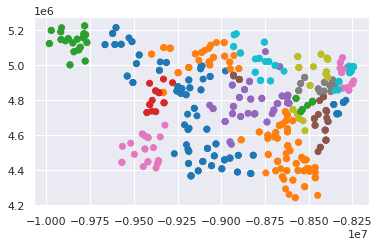

In [ ]:
print(f"There are {len(station_gdf)} stations.")
station_gdf.plot("zone")
plt.show()

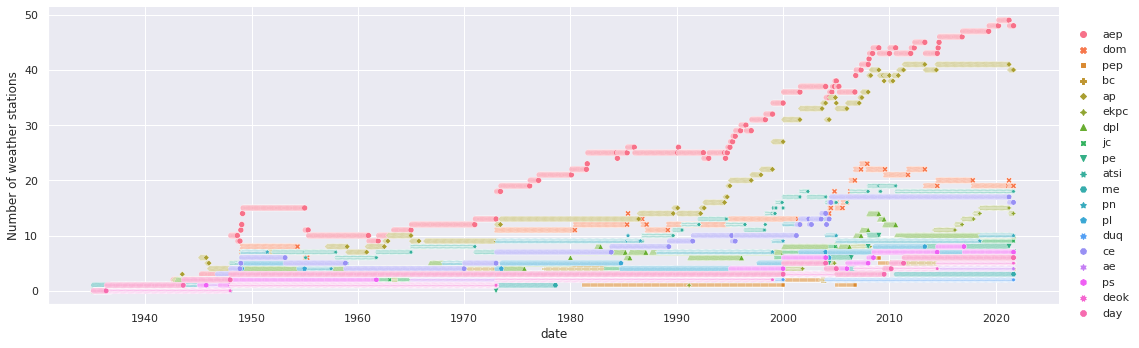

In [ ]:
# Plot of the number of stations per zone per month.
stations_date_df = pd.DataFrame(
    {
        "date": pd.date_range(
            station_gdf["begin"].min(), station_gdf["end"].max(), freq="M"
        )
    }
).set_index("date")

for index, row in station_gdf.iterrows():
    date_range = pd.date_range(row.begin, row.end, freq="M")
    if row.zone not in stations_date_df.columns:
        stations_date_df[row.zone] = 0
    stations_date_df.loc[date_range, row.zone] += 1
stations_date_df


sns.relplot(data=stations_date_df, aspect=3)
plt.ylabel("Number of weather stations")
plt.show()

### Join and download bigquery

Now we want to join the stations onto the actual dataset to download only the relevant rows.
1. First we convert back to a regular pandas dataframe.
2. Then we upload to bigquery.
3. Join onto the noaa dataset.
4. Download bigquery.

In [ ]:
pd.DataFrame(station_gdf[["usaf", "wban", "zone"]]).to_gbq(
    f"cis545.stations", if_exists="replace"
)

100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]


In [ ]:
def download_noaa(year):
    filename = f"data/noaa/{year}.parquet"
    if os.path.exists(filename):
        return
    bq.query(
        f"""
    SELECT *
    FROM `cis545.stations` s
    INNER JOIN `bigquery-public-data.noaa_gsod.gsod{year}` w
    ON s.usaf = w.stn
    WHERE s.usaf != '999999'

    UNION ALL

    SELECT *
    FROM `cis545.stations` s
    INNER JOIN `bigquery-public-data.noaa_gsod.gsod{year}` w
    ON s.wban = w.wban
    WHERE (s.usaf = '999999' or w.stn = '999999') and  s.wban != '99999'
    """
    ).result().to_dataframe().to_parquet(filename)


with ThreadPoolExecutor() as e:
    e.map(download_noaa, range(1998, 2020 + 1))

In [ ]:
noaa_cols_df = (
    bq.query(
        """
SELECT column_name, description
FROM `bigquery-public-data.noaa_gsod.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS` t
WHERE t.table_name = 'gsod2020'
"""
    )
    .result()
    .to_dataframe()
)

### Load and clean data

In [ ]:
noaa_raw_sdf = spark.read.parquet(*glob("data/noaa/*.parquet")).repartition(128)

In [ ]:
noaa_raw_sdf.count()

3248322

The column descriptors are as follows.

In [ ]:
from IPython.display import HTML

HTML(noaa_cols_df.to_html())

,column_name,description
0,stn,Cloud - GSOD NOAA
1,wban,"WBAN number where applicable--this is the historical ""Weather Bureau Air Force Navy"" number - with WBAN being the acronym"
2,date,Date of the weather observations
3,year,The year
4,mo,The month
5,da,The day
6,temp,Mean temperature for the day in degrees Fahrenheit to tenths. Missing = 9999.9
7,count_temp,Number of observations used in calculating mean temperature
8,dewp,Mean dew point for the day in degreesm Fahrenheit to tenths. Missing = 9999.9
9,count_dewp,Number of observations used in calculating mean dew point


In [ ]:
noaa_sdf = (
    noaa_raw_sdf.replace(["99999", "999999"], None)
    .replace([999.9, 9999.9], None)
    .select(
        # parse the date format
        F.to_date(F.concat_ws("/", "da", "mo", "year"), "dd/MM/yyyy").alias("date"),
        # usaf == stn, but one might be null
        F.coalesce("usaf", "stn").alias("usaf"),
        # wban == wban_1 but one might be null
        F.coalesce("wban", "wban_1").alias("wban"),
        "zone",
        # cast each numeric features to doubles
        *[
            F.col(c).cast("double")
            for c in [
                "temp",
                "dewp",
                "slp",
                "stp",
                "visib",
                "wdsp",
                "gust",
                "max",
                "min",
                "prcp",
                "sndp",
            ]
        ],
        # cast all the counts for the numeric features to int
        *[
            F.col(f"count_{c}").cast("int")
            for c in ["temp", "dewp", "slp", "stp", "visib", "wdsp"]
        ],
        # flag_prcp can be either "" or null this is different from I
        # we want to give them a label for the onehot encoder later
        (
            F.when(F.col("flag_prcp") == "", "ND")
            .when(F.col("flag_prcp").isNull(), "ND")
            .otherwise(F.col("flag_prcp"))
            .alias("flag_prcp")
        ),
        # flag_min/max are binary flags
        *[
            F.when(F.col(c) == "*", 1).otherwise(0).alias(c)
            for c in ["flag_max", "flag_min"]
        ],
        #
        *[
            F.col(c).cast("int")
            for c in [
                "fog",
                "rain_drizzle",
                "snow_ice_pellets",
                "hail",
                "thunder",
                "tornado_funnel_cloud",
            ]
        ],
    )
    .fillna(
        0, "sndp"
    )  # from the column description missing values usualy indicate zero
).orderBy("date")
noaa_sdf.show(5)

+----------+------+-----+----+----+----+------+----+-----+----+----+----+----+----+----+----------+----------+---------+---------+-----------+----------+---------+--------+--------+---+------------+----------------+----+-------+--------------------+
|      date|  usaf| wban|zone|temp|dewp|   slp| stp|visib|wdsp|gust| max| min|prcp|sndp|count_temp|count_dewp|count_slp|count_stp|count_visib|count_wdsp|flag_prcp|flag_max|flag_min|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+----------+------+-----+----+----+----+------+----+-----+----+----+----+----+----+----+----------+----------+---------+---------+-----------+----------+---------+--------+--------+---+------------+----------------+----+-------+--------------------+
|1998-01-01|724014| null|  ap|27.3|12.3|  null|null| 10.0| 5.5|18.1|39.2|12.2| 0.0| 0.0|        24|        24|        0|        0|         24|        24|        I|       1|       1|  0|           0|               0|   0|      0|                   0|


### One-hot encoding
The `flag_prcp` column is a string describing how the data is collected. 
There are several categories so we decided to one-hot encode it.
After we are finished encoding we split the one-hot vector into columns to aggregate later.
We are going to create a function for onehot encoding to use later.

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.functions import vector_to_array


def onehot_column(sdf, col):
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_idx").fit(sdf)
    idx_sdf = indexer.transform(sdf)
    enc_sdf = (
        OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_enc")
        .fit(idx_sdf)
        .transform(idx_sdf)
        .select(
            "*",
            *[
                # convert the onehot vector to columns
                # the last label is encoded as a zero vector
                vector_to_array(f"{col}_enc")[i].alias(f"{col}_{l}")
                for i, l in enumerate(indexer.labels[:-1])
            ],
        )
        .drop(f"{col}_idx", f"{col}_enc")
    )
    return enc_sdf


noaa_enc_sdf = onehot_column(noaa_sdf, "flag_prcp").drop("flag_prcp")
noaa_enc_sdf.show()

+----------+------+-----+----+----+----+------+------+-----+----+----+----+----+-----+----+----------+----------+---------+---------+-----------+----------+--------+--------+---+------------+----------------+----+-------+--------------------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-----------+
|      date|  usaf| wban|zone|temp|dewp|   slp|   stp|visib|wdsp|gust| max| min| prcp|sndp|count_temp|count_dewp|count_slp|count_stp|count_visib|count_wdsp|flag_max|flag_min|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|flag_prcp_G|flag_prcp_I|flag_prcp_ND|flag_prcp_D|flag_prcp_A|flag_prcp_H|flag_prcp_B|flag_prcp_C|
+----------+------+-----+----+----+----+------+------+-----+----+----+----+----+-----+----+----------+----------+---------+---------+-----------+----------+--------+--------+---+------------+----------------+----+-------+--------------------+-----------+-----------+------------+-----------+-----------+-----------+-----

Now since all the columns are numeric we aggregate them for each date and zone. We compute the mean and standard deviation. Note that this includes the categorical columns we had before.

In [ ]:
excl_cols = ["date", "usaf", "wban", "zone"]
numerical_cols = [c for c in noaa_enc_sdf.columns if c not in excl_cols]
noaa_gb_sdf = noaa_enc_sdf.groupby("date", "zone").agg(
    *(F.mean(F.col(c)).alias(f"{c}_mean") for c in numerical_cols),
    *(F.stddev(F.col(c)).alias(f"{c}_std") for c in numerical_cols),
)
noaa_features = [c for c in noaa_gb_sdf.columns if c not in ["date", "zone"]]
noaa_gb_sdf.show()

+----------+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+---------------------+---------+------------+-------------------------+-------------------+-------------------+------------------+-------------------+----------------+-------------------+----------------+--------------------+-------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+

### Fill in missing values
Now `noaa_gb_sdf` has one set of features per datetime and zone.
However a lot of them are still missing.
Let's get the fraction of missing values for each column.

In [ ]:
noaa_gb_sdf.select(
    [
        F.sum(F.col(c).isNull().cast("int")).alias(f"{c} null")
        for c in noaa_gb_sdf.columns
    ]
).show()

+---------+---------+--------------+--------------+-------------+-------------+---------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+-------------------+-------------------+---------------------+--------------------+------------------+------------------+-------------+----------------------+--------------------------+--------------+-----------------+------------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------+-------------+------------+------------+--------------+-------------+-------------+------------+------------+-------------+-------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+-----------------+------------+---------------------+--------

Since in general weather changes slowly over time (with exceptions).
For each missing value we will take the average over the past 7 days and the next 7 days.
Then for whatever values that are left we fill with the mean over all columns.

We will fallback on using the mean for the remaining columns.

In [ ]:
window_size = 7 * (24 * 60 * 60)
w_sliding = (
    Window()
    .partitionBy("zone")
    .orderBy(F.unix_timestamp("date"))
    .rangeBetween(-window_size, window_size)
)
w_all = Window().partitionBy("zone")
noaa_fill_sdf = (
    noaa_gb_sdf.select(
        "date",
        "zone",
        *[
            F.when(F.col(c).isNull(), F.mean(c).over(w_sliding))
            .otherwise(F.col(c))
            .alias(c)
            for c in noaa_features
        ]
    )
    .select(
        "date",
        "zone",
        *[
            F.when(F.col(c).isNull(), F.mean(c).over(w_all))
            .otherwise(F.col(c))
            .alias(c)
            for c in noaa_features
        ]
    )
    .cache()
)

In [ ]:
noaa_fill_sdf.select(
    [
        F.sum(F.col(c).isNull().cast("int")).alias(f"{c} null")
        for c in noaa_fill_sdf.columns
    ]
).show()

+---------+---------+--------------+--------------+-------------+-------------+---------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+-------------------+-------------------+---------------------+--------------------+------------------+------------------+-------------+----------------------+--------------------------+--------------+-----------------+------------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------+-------------+------------+------------+--------------+-------------+-------------+------------+------------+-------------+-------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+-----------------+------------+---------------------+--------

As you can see we filled in the missing values. We do not show this above, but filling the missing values with a window was not particularly effective (it only helped with a few rows).
However the only two columns with missing values were `slp` and `stp`, so we are not too worried.

### Vector Assembly

Finally, let's assemble our features computed above into a vector.
We will need `date` and `zone` to join with the energy dataset.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# keep the names of the vec
features_sdf = (
    VectorAssembler(inputCols=noaa_features, outputCol="features")
    .transform(noaa_fill_sdf)
    .select("date", "zone", "features")
)

Some of the features are strongly correlated so it might be necessary to perform PCA.

It makes sense that the counts are correlated. They describe how many measurements were taken to get the daily average value.
Most likely the value is the same across all measurement types (temp, dewp). Similarly, min and max temperature will be correlated due to seasonality.

## Combining the datasets

Our energy data is hourly, but the weather data is a daily average. 
We decided it would be best to predict daily energy consumption instead of trying to augment the weather data.
We still have over 62k rows of data.population_sdf = spark.createDataFrame(population_df)

In [ ]:
population_sdf = spark.createDataFrame(population_df)

data_sdf = (
    pjm_sdf.join(
        features_sdf,
        [
            pjm_sdf.zone == features_sdf.zone,
            pjm_sdf.date == features_sdf.date,
        ],
    )
    .join(population_sdf, "zone", how="left")
    .select(
        pjm_sdf.zone,
        pjm_sdf.date,
        "mw",
        (F.col("mw") / F.col("population") * 1e3).alias("mw_per_capita"),
        "features",
    )
    .select("*", F.unix_timestamp("date").alias("unix_timestamp"))
)

# let's onehot encode the zone too, there might be variations from zone to zone
data_sdf = onehot_column(data_sdf, "zone")

# add unix_timestamp to the feature vector since there probably is
# an upward growth in energy consumption per capita over time
new_features = [
    c
    for c in data_sdf.columns
    if c not in ["zone", "date", "mw", "mw_per_capita", "features"]
]
combined_features = noaa_features + new_features
data_sdf = VectorAssembler(
    inputCols=["features"] + new_features, outputCol="new_features"
).transform(data_sdf)

# rename the columns back
data_sdf = (
    data_sdf.select(
        "zone",
        "date",
        "mw",
        "mw_per_capita",
        F.col("new_features").alias("features"),
    )
    .repartition(128)
    .cache()
)
data_sdf.show()

+----+----------+-------+------------------+--------------------+
|zone|      date|     mw|     mw_per_capita|            features|
+----+----------+-------+------------------+--------------------+
| day|2008-08-11|50249.0| 41.69292837562052|(85,[0,1,2,3,4,5,...|
| day|2005-04-19|47694.0| 39.57297709301369|(85,[0,1,2,3,4,5,...|
| day|2018-06-25|51065.0| 42.36998522360767|(85,[0,1,2,3,4,5,...|
| day|2012-04-29|36421.0| 30.21946992713238|(85,[0,1,2,3,4,5,...|
| day|2007-01-09|55761.0| 46.26638100565137|(85,[0,1,2,3,4,5,...|
| day|2010-04-19|42409.0|35.187872385155735|(85,[0,1,2,3,4,5,...|
| day|2005-07-12|62093.0|51.520209389786956|(85,[0,1,2,3,4,5,...|
| day|2019-01-06|41432.0| 34.37722956593583|(85,[0,1,2,3,4,5,...|
| day|2006-08-08|63012.0|  52.2827280703019|(85,[0,1,2,3,4,5,...|
| day|2007-01-19|56265.0|46.684563176466966|(85,[0,1,2,3,4,5,...|
| day|2016-05-22|35601.0|29.539094173027642|(85,[0,1,2,3,4,5,...|
| day|2018-06-04|46976.0|38.977233444907355|(85,[0,1,2,3,4,5,...|
| day|2008

# EDA

## Hourly Variations

Ok I know we said we aren't gonna look at the hourly variations. However, just to see what we are missing, let's do some visualization on them.

Plotting a timeseries of an hourly dataset over several year's isn't too useful.
Instead we examine the hourly variation using a histogram and will use a `relplot` with a daily average.

For now, let's look at when do peak hours occur on each day. To do this we take the largest result over a window partitioned on date and zone.

In [ ]:
w = Window.partitionBy(F.to_date("datetime").alias("date"), "zone").orderBy(
    F.col("mw").desc()
)
hour_df = (
    pjm_hourly_sdf.withColumn("row", F.row_number().over(w))
    .where(F.col("row") == 1)
    .select(
        "zone",
        F.hour("datetime").alias("hour"),
        F.month("datetime").alias("month"),
        F.year("datetime").alias("year"),
    )
).toPandas()

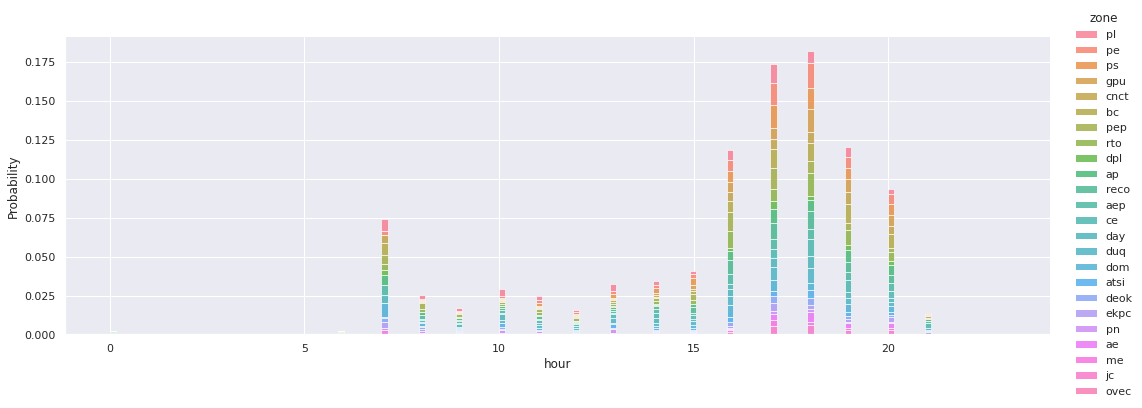

In [ ]:
plot_params = dict(
    data=hour_df,
    x="hour",
    hue="zone",
    multiple="stack",
    stat="probability",
    aspect=3,
)
sns.displot(**plot_params)
plt.show()

This aligns with our intuition. Most of the energy use is in the mornings and afternoons: when people are getting ready for work and returning home. Let's see if this changes from month to month. 

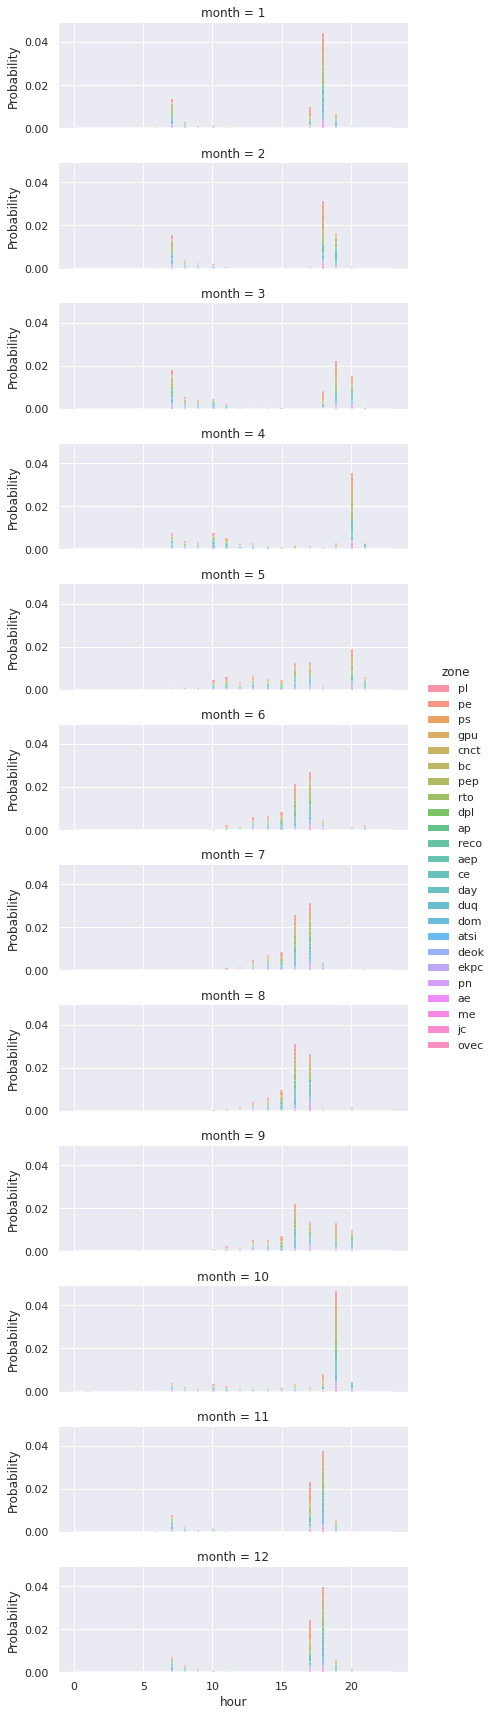

In [ ]:
sns.displot(**plot_params, height=2, row="month")
plt.show()

Okay... It is surprising that peak hours change from month to month. 

Hypothesis: It seems that people wake up early Jan-March and start waking up later on. Perhaps what is actually happening is evening consumption is much larger in the other months. 
In the summer there is air conditioning, which uses a lot of energy in the afternoon. We don't use as much air conditioning in the morning, since mornings are typically cool after the night.
In the winter (Jan-March) heating does not use electricity, but gas. So it would make sense that afternoons are not as likely to be a peak.

There is a lot more things we could do with hourly variations, but it will not help with our modeling. Let's just consider the daily averages for now.

## Time Series
Let's look at the data over time by zone. Hously data is a bit too difficult to understand.
As we can see, there must have been some kind of misunderstanding during
population scaling making dom have much larger energy usage per capita than 
other regions. For this reason we drop dom from out dataset.

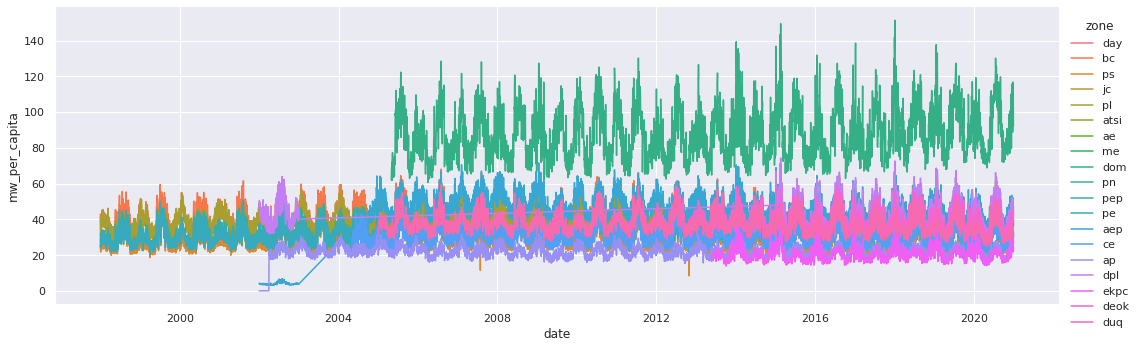

In [ ]:
data_df = data_sdf.select("mw_per_capita", "zone", "date").toPandas()
sns.relplot(
    data=data_df, x="date", y="mw_per_capita", hue="zone", kind="line", aspect=3
)
plt.show()

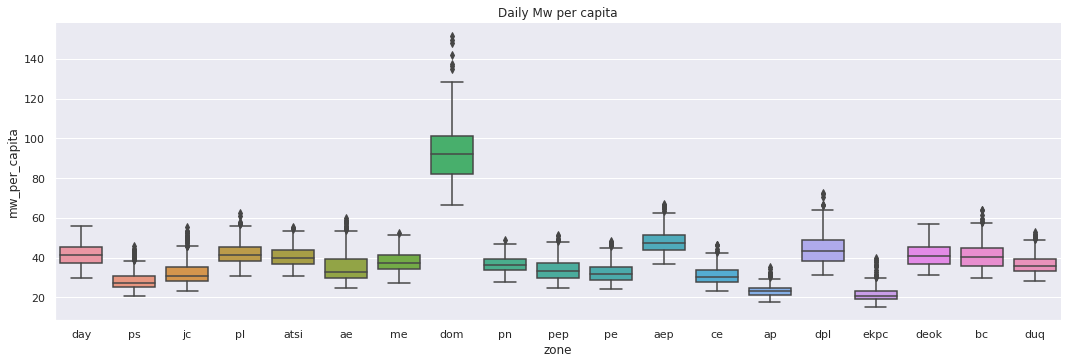

In [ ]:
data_df = (
    data_sdf.where(F.year("date") == 2018)
    .select("date", "zone", "mw_per_capita")
    .toPandas()
)
ax = sns.catplot(data=data_df, x="zone", y="mw_per_capita", kind="box", aspect=3)
plt.title("Daily Mw per capita")
plt.show()

The `dom` region seems to be an outlier for power consumption. We will exclude it.

## Correlation matrix
We plot the correlation matrix to see if it is necessary to perform dimensionality reduction.

21/12/15 04:06:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/12/15 04:06:48 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


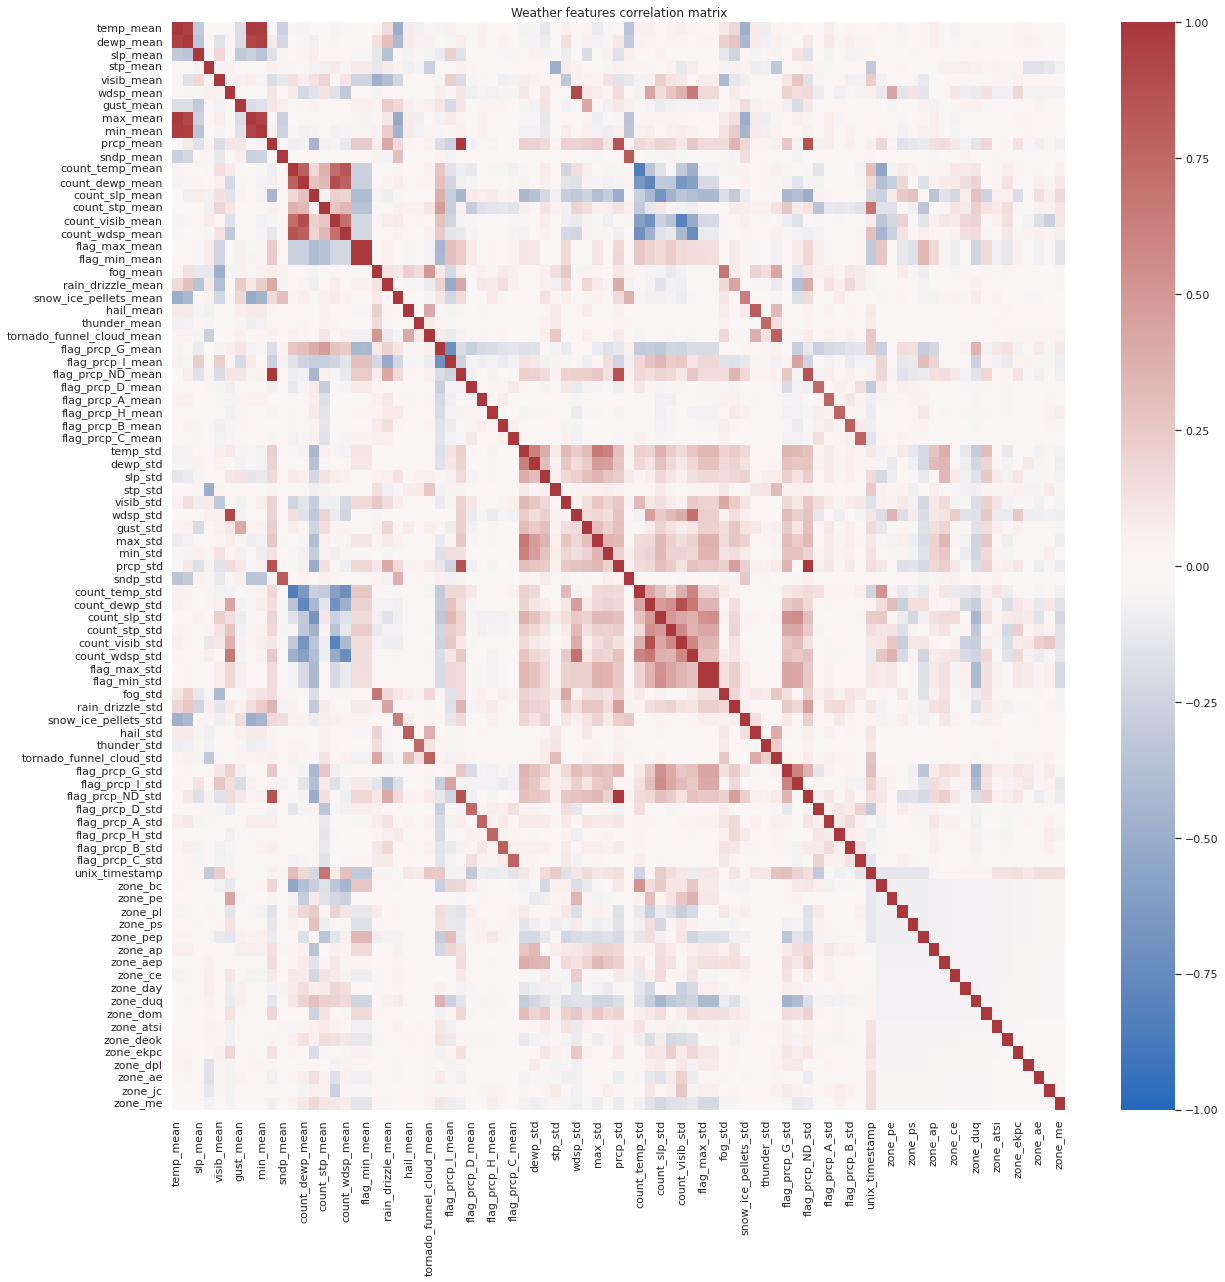

In [ ]:
from pyspark.ml.stat import Correlation

corr_mat = (
    Correlation.corr(data_sdf, "features").collect()[0]["pearson(features)"].toArray()
)
corr_df = pd.DataFrame(corr_mat, combined_features, combined_features)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, cmap="vlag", vmax=1, vmin=-1)
plt.title("Weather features correlation matrix")
plt.show()

# Test Set
Instead of selecting a random sample let's select 2019 as the test set.
We essentially want to evaluate how our model would perform in the future, on never before seen data.
We drop 2020-2021 data because COVID would have likely affected the results dramatically.
Additionally, we drop the `dom` region since it's energy demand per capita is much higher than the other regions (outlier).

In [ ]:
zones = [r[0] for r in data_sdf.select("zone").distinct().collect()]
train_sdf = data_sdf.where((F.year("date") < 2019) & (F.col("zone") != "dom"))
test_sdf = data_sdf.where((F.year("date") == 2019) & (F.col("zone") != "dom"))

In [ ]:
train_sdf.show(5)

+----+----------+-------+-----------------+--------------------+
|zone|      date|     mw|    mw_per_capita|            features|
+----+----------+-------+-----------------+--------------------+
| day|2008-08-11|50249.0|41.69292837562052|(85,[0,1,2,3,4,5,...|
| day|2005-04-19|47694.0|39.57297709301369|(85,[0,1,2,3,4,5,...|
| day|2018-06-25|51065.0|42.36998522360767|(85,[0,1,2,3,4,5,...|
| day|2012-04-29|36421.0|30.21946992713238|(85,[0,1,2,3,4,5,...|
| day|2007-01-09|55761.0|46.26638100565137|(85,[0,1,2,3,4,5,...|
+----+----------+-------+-----------------+--------------------+
only showing top 5 rows



Our correlation matrix plotted above shows that some features are correlated.
Therefore we do PCA to reduce the dimensionality.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA, StandardScaler

scaler = StandardScaler(
    withMean=True,
    withStd=True,
    inputCol="features",
    outputCol="features_scaled",
)
pca = PCA(k=85, inputCol="features_scaled", outputCol="features_pca")

21/12/15 04:06:52 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/12/15 04:06:52 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


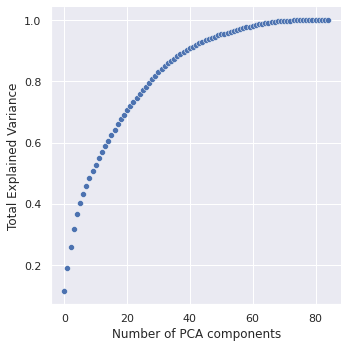

The first 65 components explain 99% of variance.


In [ ]:
explained_variance = (
    Pipeline(stages=[scaler, pca]).fit(train_sdf).stages[1].explainedVariance.toArray()
)
sns.relplot(data=np.cumsum(explained_variance))
plt.ylabel("Total Explained Variance")
plt.xlabel("Number of PCA components")
plt.show()

pca_k = np.argmax(np.cumsum(explained_variance) > 0.99) + 1
print(f"The first {pca_k} components explain 99% of variance.")

We keep the largest 65 PCA features since they cover 99% of the explained variance.

In [ ]:
pca.setParams(k=pca_k)
preprocess = Pipeline(stages=[scaler, pca]).fit(train_sdf)

In [ ]:
train_sdf = preprocess.transform(train_sdf).repartition(128).cache()
test_sdf = preprocess.transform(test_sdf).repartition(128).cache()

In [ ]:
year_train = train_sdf.select(F.year("date")).rdd.map(lambda x: x[0]).collect()
x_train = np.stack(
    train_sdf.select("features_scaled").rdd.map(lambda x: x[0].toArray()).collect(),
    axis=0,
)
x_train_pca = np.stack(
    train_sdf.select("features_pca").rdd.map(lambda x: x[0].toArray()).collect(),
    axis=0,
)
y_train = np.stack(
    train_sdf.select("mw_per_capita").rdd.map(lambda x: x[0]).collect(), axis=0
)
x_test = np.stack(
    test_sdf.select("features_scaled").rdd.map(lambda x: x[0].toArray()).collect(),
    axis=0,
)
x_test_pca = np.stack(
    test_sdf.select("features_pca").rdd.map(lambda x: x[0].toArray()).collect(),
    axis=0,
)
y_test = np.stack(
    test_sdf.select("mw_per_capita").rdd.map(lambda x: x[0]).collect(), axis=0
)

In [ ]:
np.savez(
    "data/data.npz",
    year_train=year_train,
    x_train=x_train,
    x_train_pca=x_train_pca,
    y_train=y_train,
    x_test=x_test,
    x_test_pca=x_test_pca,
    y_test=y_test,
)

# Modeling

In [ ]:
data = np.load("data/data.npz")
year_train = data["year_train"]
x_train = data["x_train"]
x_train_pca = data["x_train_pca"]
y_train = data["y_train"]
x_test = data["x_test"]
x_test_pca = data["x_test_pca"]
y_test = data["y_test"]

For validation we can't just sample randomly, otherwise all we are doing is interpolating between points (overfitting).
Instead for cross-validation we want to leave out individual years.
We can achieve this with `sklearn.model_selection.GroupKFold`.

In [ ]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(5)
splits = list(gkf.split(x_train, y_train, year_train))

## Linear regression

Just to start let's do a linear regression to have a feel how the weather impacts energy use.
We tried several regularization coefficients and elastic net parameters.

In [ ]:
from scipy.stats import uniform
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

params = dict(
    alpha=uniform(0.01, 5), l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
)
search = RandomizedSearchCV(
    ElasticNet(), params, n_iter=1000, n_jobs=-1, random_state=0, cv=splits
)

In [ ]:
search.fit(x_train, y_train)
search.best_params_

{'alpha': 0.11834465442932594, 'l1_ratio': 0.9}

In [ ]:
train_mse = mean_squared_error(search.predict(x_train), y_train)
test_mse = mean_squared_error(search.predict(x_test), y_test)
print(train_mse, test_mse)

32.380085104378054 80.86979974621615


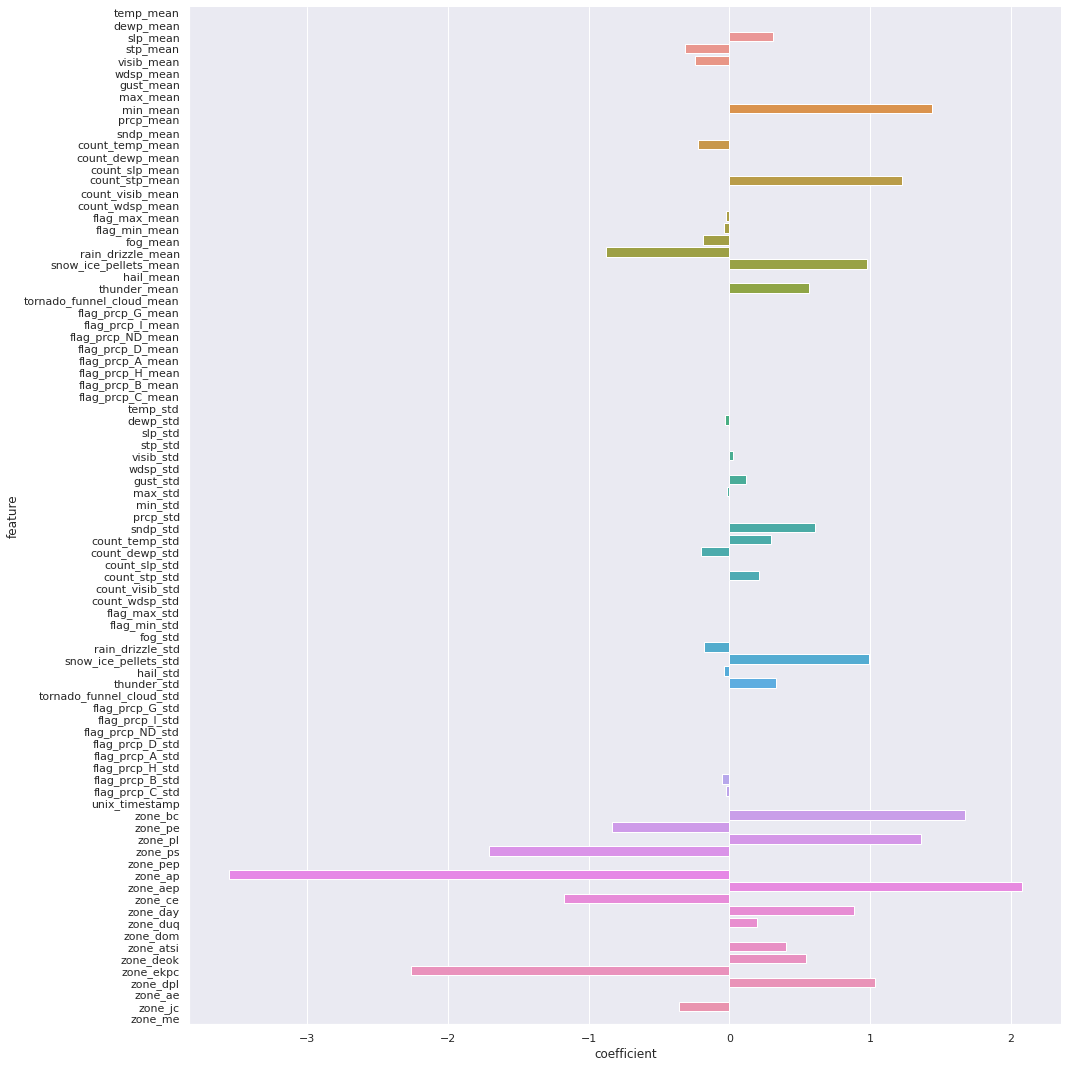

In [ ]:
coeff_df = pd.DataFrame(
    {
        "feature": combined_features,
        "coefficient": search.best_estimator_.coef_,
    }
)
sns.catplot(data=coeff_df, x="coefficient", y="feature", height=15, kind="bar")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV

params = dict(
    max_features=["auto", "sqrt", "log2"],
    max_depth=[5, 10, 20, 50, 100],
    min_impurity_decrease=[0, 0.01, 0.1],
    min_samples_split=[2, 4, 8],
    min_samples_leaf=[2, 4, 8],
)
rf = RandomForestRegressor(n_estimators=32, n_jobs=-1)
search = BayesSearchCV(rf, params, n_jobs=-1, cv=splits)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

/opt/conda/lib/python3.9/site-packages/skopt/searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [ ]:
rf = RandomForestRegressor(n_estimators=256, n_jobs=-1, **search.best_params_)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=100, min_samples_leaf=2, n_estimators=256,
                      n_jobs=-1)

In [ ]:
train_mse = mean_squared_error(search.predict(x_train), y_train)
test_mse = mean_squared_error(search.predict(x_test), y_test)
print(train_mse, test_mse)

0.9473860033661229 7.247192195708585


## (S)ARIMA
Background SARIMA

Introducing adjusted month variable does not affect linear regression model,
suggesting yearly seasonality has little to no effect on energy usage.

adjusted year has a coefficient in model suggesting some data manipulation
is necessary to make data stationary.

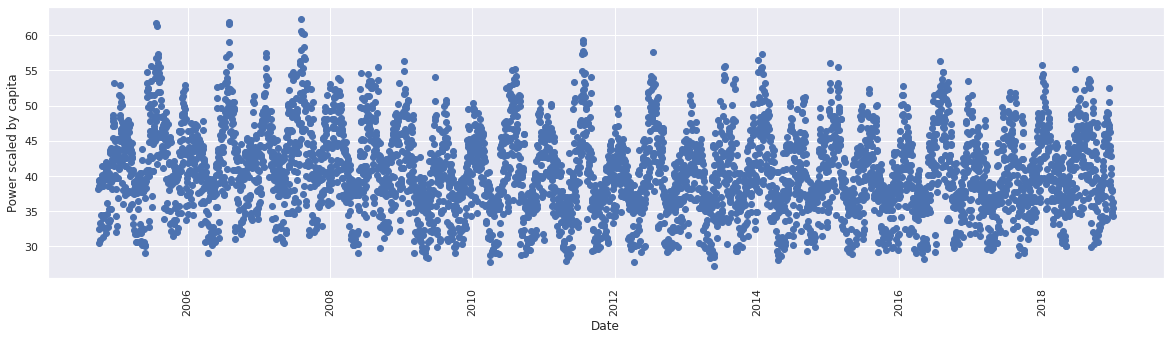

In [ ]:
x = train_sdf.select("date").where(train_sdf.zone == "day").collect()
y = train_sdf.select("mw_per_capita").where(train_sdf.zone == "day").collect()
plt.figure(figsize=[20, 5])
plt.scatter(x, y)
plt.ylabel("Power scaled by capita")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Let's have a look at the Augmented Dickey-Fuller test, which tests for seasonality
As the test statistic is significantly above the p-value (for both test and train data), we reject the null hypothesis that the data is stationary: we conclude it is non-stationary.
Creating a differenced series - apply lambda function

In [ ]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(train_sdf.select("mw_per_capita").collect())
print(f"ADF test Train data: {ad_fuller_result[0]}")
print(f"p-value Train data: {ad_fuller_result[1]}")

ad_fuller_result2 = adfuller(test_sdf.select("mw_per_capita").collect())
print(f"ADF test Test data: {ad_fuller_result2[0]}")
print(f"p-value Test data: {ad_fuller_result2[1]}")

ADF test Train data: -30.620734752097857
p-value Train data: 0.0
ADF test Test data: -18.827201506647285
p-value Test data: 2.022130001084931e-30


We plot Partial Autocorrelation and Autocorrelation to see what kind of
seasonal autoregressive process we are looking at.

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


AttributeError: 'list' object has no attribute 'shape'

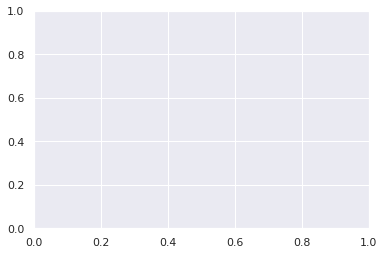

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(y)
plot_acf(y)

We would like to optimize the parameters of our sarima model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook


def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
    Return dataframe with parameters, corresponding AIC and SSE

    parameters_list - list with (p, q, P, Q) tuples
    d - integration order
    D - seasonal integration order
    s - length of season
    exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(
                exog,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p,q)x(P,Q)", "AIC"]
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df


# p = range(0, 4, 1)
# d = 1 get this value from
# q = range(0, 4, 1)
# P = range(0, 4, 1)
D = 1
# Q = range(0, 4, 1)
s = 4

## Deep Learning

### checkup
* Try autoregressive models (SARIMA)
    * see if one region vs two regions vs multiple
* Aggregate weather data for each zone
    * weighted mean + variance? Maybe other features (may not be able)
* linear regressions (+kernels)